In [ ]:
# import libraries

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from tqdm import tqdm

%matplotlib inline

In [ ]:
# determine the device where to perform calculations (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# it is necessary to unpack the dataset into the environment:
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/hotdog.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/dataset')

In [ ]:
#function to display images
def image_shower(images, labels, n=4):
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i + 1)
        image = image/ 2 + 0.5
        plt.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
    print("Real Labels: ", ' '.join('%5s' % classes[label] for label in labels[:n]))
#class names
classes = ("hotgot", "not_hot_dog")

#path to dataset
PATH = "/content/dataset"

In [ ]:
# set what transformations need to be done with each image
transform = transforms.Compose(
    [transforms.Resize((64,64)),  #resize images
     transforms.ToTensor(),   #translate into the format that the neural network needs - tensor
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]) # let's normalize the image

#loading training and test datasets
trainset = torchvision.datasets.ImageFolder(os.path.join(PATH, "train"), transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, num_workers=0, shuffle=True)

testset = torchvision.datasets.ImageFolder(os.path.join(PATH, "test"), transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, num_workers=0, shuffle=True)


Real Labels:  hotgot not_hot_dog not_hot_dog hotgot


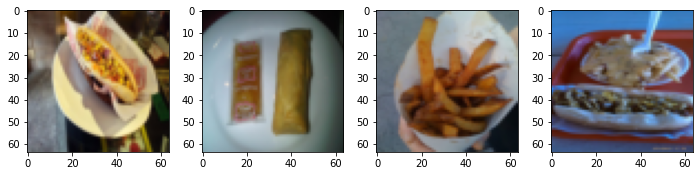

In [ ]:
#Let's check how our loader works and look at a couple of images
images, labels = next(iter(trainloader))
image_shower(images, labels)

In [ ]:
#load our model
model = torchvision.models.resnet18(pretrained=True)
#freeze the weights
for param in model.parameters():
    param.require = False

# since we have 2 classes, we need to redefine the last layer of the network for our task
# the pretrained network had 1000 classes at the output, so in the video I said we change 1000 to 2
model.fc = nn.Linear(512, 2)

In [ ]:
#Set the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

In [ ]:
#Neural network training will be here

epochs = 10   #количество эпох (сколько раз будем тренировать)
model.to(device) #переносим нашу модель на GPU

for epoch in range(epochs):
    running_loss = 0.0
    #now in the loop we go through our data loader
    for i, data in tqdm(enumerate(trainloader)):
        #each batch is also placed on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)
        #reset the accumulated gradient
        optimizer.zero_grad()
        #run the images through the model to get the prediction
        outputs = model(inputs)
        #calculate the loss function (how well predicted)
        loss = criterion(outputs, labels)
        #calculate gradients (reverse pass)
        loss.backward()
        #do the optimizer step (update the weights)
        optimizer.step()

        running_loss += loss.item()

    print ("Epoch {} - Training loss: {} ".format(epoch, running_loss/len(trainloader)))

In [ ]:
#calculate the accuracy of our classifier
correct = 0
total = 0
with torch.no_grad():
    #translate the model into inference mode
    model.eval()
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        #get our predictions
        _, predicted = torch.max(outputs.data, 1)
        #count the total number of images
        total += labels.size(0)
        #count the number of accurately classified images
        correct += (predicted == labels).sum().item()
print("Accuracy: %d" %(100 * correct/total))


Accuracy: 68


Real Labels:  not_hot_dog not_hot_dog hotgot not_hot_dog
Predicted:  not_hot_dog not_hot_dog hotgot not_hot_dog


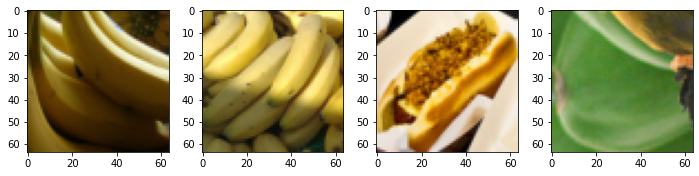

In [ ]:
images, labels = next(iter(testloader))
image_shower(images, labels)

outputs = model(images.to(device))

_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join("%5s" %classes[predict] for predict in predicted[:4]))